## DU Data Scientist project 2024
### Date: 2024-10-16
#### Author : Jonathan Kitt

## <u>Part 1 - Using the reciprocal of the cumulative distribution</u>

In [132]:
# Load the python libraries we will be using for the analysis

import numpy as np               # for calculations
import scipy as sp               # for scientific calculation
import matplotlib.pyplot as plt  # for plots

In [3]:
# Set random seed for reproducibility
np.random.seed(0)

In [5]:
# Define a percent point function

def ppf(x, lambda_val = 1):

    '''
    Calculate percent point (or quantile) function, or ppf
    for a vector of random probabilities

    ---------------
    Parameters
    ---------------
    
    x: vector of random probabilities
    
    lambda_val: parameter value (defaults to 1)

    ---------------
    Returns
    ---------------

    A vector of values resulting from applying a percent point function to a vector
    of probabilities for a given lambda parameter (defaults to 1)
    '''
    
    res = (np.log(x / (1 - x))) / lambda_val
    
    return res

### _Question 1_

In [7]:
# Generate a sample of 10**5 random probabilities p_k, uniformily distributed in [0, 1]

p_k = np.random.uniform(low = 0, high = 1, size = 10**5)

# Check the size of the sample we generated

print(len(p_k))

# Print the first five elements of the sample

print(p_k[0:5])

100000
[0.5488135  0.71518937 0.60276338 0.54488318 0.4236548 ]


In [9]:
# For each random value p_k, estimate x_k for a lambda parameter equal to 1

x_k = ppf(x = p_k)

# Print the first five elements of x_k

print(x_k[0:5])

[ 0.19587791  0.92072284  0.41699258  0.1800173  -0.30778782]


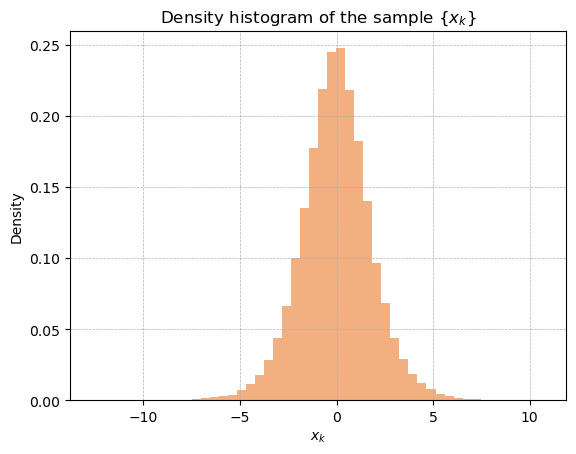

In [11]:
# Draw the density histogram of the sample x_k

plt.hist(x = x_k, bins = 50, color = '#e66100', density = True, alpha = 0.5)
plt.title('Density histogram of the sample {$x_k$}')
plt.xlabel('$x_k$')
plt.ylabel('Density')
plt.grid(linestyle = '--', linewidth = 0.5)

### _Question 2_

In [13]:
# Define a probability density function

def pdf(x, lambda_val = 1):
    '''
    Calculate probability density function, or pdf
    for a vector of random probabilities

    ---------------
    Parameters
    ---------------
    
    x: vector of random probabilities
    
    lambda_val: parameter value (defaults to 1)

    ---------------
    Returns
    ---------------

    A vector of values resulting from applying a probability density function to a vector
    of probabilities for a given lambda parameter (defaults to 1)
    '''
    res = (lambda_val / 4) * (1 / np.cosh(lambda_val * x / 2))**2
    return res

In [15]:
# Derive the explicit expression of the probability density function (pdf) on the x_k values for lambda = 1

f_x = pdf(x = x_k)

# Print the first five elements

print(f_x[0:5])

[0.24761724 0.20369354 0.23943969 0.2479855  0.24417141]


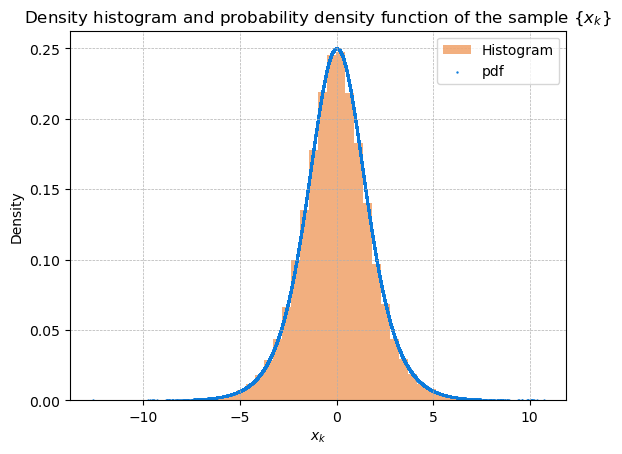

In [17]:
# Superimpose the f_x(x_k, 1) density curve on the sample histogram 

plt.hist(x = x_k, bins = 50, color = '#e66100', alpha = 0.5, density = True, label = 'Histogram')
plt.scatter(x = x_k, y = f_x, label = 'pdf', color = '#0c7bdc', s = 0.5)
plt.title('Density histogram and probability density function of the sample {$x_k$}')
plt.xlabel('$x_k$')
plt.ylabel('Density')
plt.legend()
plt.grid(linestyle = '--', linewidth = 0.5)

The density curve matches the density histogram rather well.

### _Question 3_

In [19]:
# Define function to calculate negative log-likelihood

def neg_ll(lambda_val, x):

    '''
    Calculate negative log-likelihood for a vector of random probabilities
    and a given lambda parameter

    ---------------
    Parameters
    ---------------
    
    x: vector of random probabilities
    
    lambda_val: parameter value

    ---------------
    Returns
    ---------------

    A vector of log likelihoods
    '''

    res = -np.sum(np.log(pdf(x, lambda_val)))

    return res

In [21]:
# Extract the ML estimator lambda_est that minimizes this function
# We use the minimize() function, from the SciPy 'optimize' module, with an initial guess (x0) of 1,
# and the 'Nelder-Mead' solver method.

fitres = sp.optimize.minimize(neg_ll, x0 = [1], args = (x_k), method = 'Nelder-Mead')

# Extract the estimator value for lambda from the fitres object

lambda_est = fitres.x[0]

print(f'The lambda estimator that minimizes the defined maximum likelihood function has a value of {lambda_est:.5f}')

The lambda estimator that minimizes the defined maximum likelihood function has a value of 0.99824


The lambda estimator value is very close to the expected value of 1.

### _Question 4_

In [96]:
# Evaluate the corresponding uncertainty sigma_lb_est, using the graphical delta ln log likelihood = -/+ 1/2 method

# First, we create a linear space for theoretical lambda values. 
# We define the limits as lb_est - 0.005 and lb_est + 0.05

lb_theo = np.linspace(lambda_est - 0.005, lambda_est + 0.005, 100)

# We then calculate the neg likelihood values for each of the x_k elements, using the range of lambda values we just defined.
# We subtract the fitres.fun parameter.
x_k_ll = [neg_ll(lambda_val = i, x = x_k) - fitres.fun for i in lb_theo]

In [124]:
# Extract the minimal value for x_k_ll
min_x_k_ll = min(x_k_ll)
print(min_x_k_ll)  # very close to 0

9.562197374179959e-05


In [162]:
# We create a pandas dataframe containing the lb_theo values and corresponding x_k_ll values
# We do this to facilitate the evaluation of the uncertainty

df = pd.DataFrame({'lb_theo': lb_theo,
                  'x_k_ll': x_k_ll})
print(df)

     lb_theo    x_k_ll
0   0.993242  1.808819
1   0.993343  1.736537
2   0.993444  1.665733
3   0.993545  1.596407
4   0.993646  1.528559
..       ...       ...
95  1.002838  1.504031
96  1.002939  1.570949
97  1.003040  1.639320
98  1.003141  1.709142
99  1.003242  1.780416

[100 rows x 2 columns]


In [196]:
# We add a new column containing the difference between the x_k_ll values and the minimal value for x_k_ll + 0.5
df = df.assign(diff = x_k_ll - (min_x_k_ll + 0.5))
print(df)

# We add a column containing the absolute values for diff
df = df.assign(diff_abs = df['diff'].abs())
print(df)

     lb_theo    x_k_ll      diff  diff_abs
0   0.993242  1.808819  1.308724  1.308724
1   0.993343  1.736537  1.236442  1.236442
2   0.993444  1.665733  1.165638  1.165638
3   0.993545  1.596407  1.096312  1.096312
4   0.993646  1.528559  1.028463  1.028463
..       ...       ...       ...       ...
95  1.002838  1.504031  1.003935  1.003935
96  1.002939  1.570949  1.070854  1.070854
97  1.003040  1.639320  1.139224  1.139224
98  1.003141  1.709142  1.209047  1.209047
99  1.003242  1.780416  1.280321  1.280321

[100 rows x 4 columns]
     lb_theo    x_k_ll      diff  diff_abs
0   0.993242  1.808819  1.308724  1.308724
1   0.993343  1.736537  1.236442  1.236442
2   0.993444  1.665733  1.165638  1.165638
3   0.993545  1.596407  1.096312  1.096312
4   0.993646  1.528559  1.028463  1.028463
..       ...       ...       ...       ...
95  1.002838  1.504031  1.003935  1.003935
96  1.002939  1.570949  1.070854  1.070854
97  1.003040  1.639320  1.139224  1.139224
98  1.003141  1.709142  1.2090

In [216]:
# We extract the lb_theo corresponding to the minimal diff values to the 'left' and 'right' sides of lambda_est.
df_left = df[lb_theo < lambda_est]
df_right = df[lb_theo > lambda_est]

In [224]:
# We sort the dataframes on absolute diff values and then extract the lb_theo value from the first row,
# corresponding to the closest value to min_x_k_ll + 0.5
left_val = df_left.sort_values('diff_abs').iloc[0]['lb_theo']
right_val = df_right.sort_values('diff_abs').iloc[0]['lb_theo']

print(left_val)
print(right_val)

0.9956664299242425
1.0009189551767677


In [234]:
# We now calculate the lambda uncertainty : 
lambda_uncertainty = (right_val - left_val) / 2
print(f"The lambda uncertainty is equal to {lambda_est} +/- {lambda_uncertainty}")
print(lambda_est - lambda_uncertainty, lambda_est + lambda_uncertainty)
print("This is consistent with the expected value of the theoretical pdf, lambda = 1")

The lambda uncertainty is equal to 0.9982421875 +/- 0.0026262626262625877
0.9956159248737375 1.0008684501262626
This is consistent with the expected value of the theoretical pdf, lambda = 1


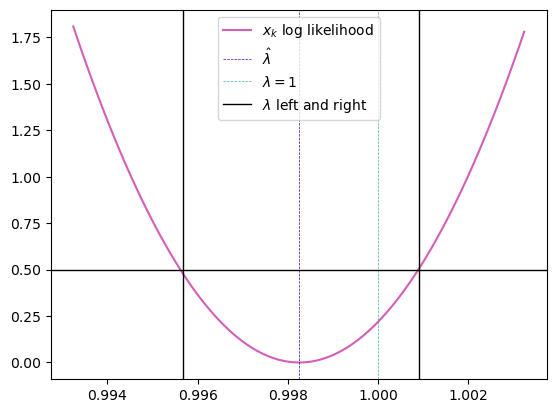

In [276]:
plt.plot(lb_theo, x_k_ll, color = '#d35fb7', label = '$x_k$ log likelihood');
plt.axvline(x = lambda_est, color = '#4b0092', label = '$\\hat{\\lambda}$', linewidth = 0.5, linestyle = "--");
plt.axvline(x = 1, color = '#40b0a6', label = '$\\lambda = 1$', linewidth = 0.5, linestyle = "--");
plt.axvline(x = left_val, color = '#000000', linewidth = 1, linestyle = "-");
plt.axvline(x = right_val, color = '#000000', label = '$\\lambda$ left and right', linewidth = 1, linestyle = "-");
plt.axhline(y = 0.5, color = '#000000', linewidth = 1, linestyle = "-");
plt.legend();
#plt.scatter(fitres['x'], 0)
#plt.vlines(x = fitres['x'], ymin = 0, ymax = 7);
#plt.vlines(x = 1, ymin = 0, ymax = 7);
#plt.hlines(y = 0.5, xmin = 0.9985, xmax = 1.0005);

In [298]:
# Produce an alternative sample of N random values according to the logistic density with the 
# SciPy generator

x_log = sp.stats.logistic.rvs(size = 10**5)

# Print the first five elements of the sample

print(x_log[0:5])

[-1.27871016  0.35260741  4.37866795  2.96284427 -0.65008011]


In [294]:
# Compare this sample distribution with our own sampling generation, by plotting the residuals histogram

hist_x_k, _ = np.histogram(x_k, bins = 25, density = True)
hist_x_log, _ = np.histogram(x_log, bins = 25, density = True)

resid = hist_x_k - hist_x_log

sigma_n = np.sqrt(hist_x_k * (10**5 / sum(hist_x_k)))  # adjust for density norm

# Normalise residuals

resid_norm = resid / sigma_n

C:\Users\jkitt\AppData\Local\Temp\ipykernel_11192\989993785.py:12: RuntimeWarning: divide by zero encountered in divide
  resid_norm = resid / sigma_n


In [ ]:
# Plot the norm resid

xs = range(0, 25)
print(list(xs))

plt.bar(x=xs, height=resid_norm);